In [ ]:
# default_exp model
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# Model

> In this notebook you create and test a Python class to hold your machine learning model.

***input***: toy dataset from data-notebook

***output***: TFF model for predicting customer paths 

***description:***

Model for simulating federated learning on predicting customer paths.

## Import relevant modules

In [ ]:
# tensorflow_federated_nightly also bring in tf_nightly, which
# can causes a duplicate tensorboard install, leading to errors.
#!pip uninstall --yes tensorboard tb-nightly

#!pip install --quiet --upgrade tensorflow-federated-nightly
#!pip install --quiet --upgrade nest-asyncio
#!pip install --quiet --upgrade tb-nightly  # or tensorboard, but not both

In [ ]:
# export
import numpy as np

import nest_asyncio

nest_asyncio.apply()

In [ ]:
%load_ext tensorboard

In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

train_test_client_split = tff.simulation.datasets.ClientData.train_test_client_split

tff.federated_computation(lambda: "Hello, World!")()

b'Hello, World!'

In [ ]:
import matplotlib.pyplot as plt
from pyarrow import feather
import pandas as pd

In [ ]:
from ml_federated_customer_path.data import create_tff_client_data_from_df

## Define notebook parameters

Remember, only simple assignments here!

In [ ]:
# this cell is tagged with 'parameters'
seed = 0
data_filepath = "data/preprocessed_data/data.f"
test_split = 0.2
toy_size = 0.1

NUM_CLIENTS = 10
NUM_EPOCHS = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 32
FEDERATED_UPDATES = 20

Make immediate derivations from the parameters:

In [ ]:
np.random.seed(seed)
tf.random.set_seed(seed)

## Import toy data for testing

In [ ]:
df = feather.read_feather(data_filepath)
df

,client_id,x,y
0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0]",5
1,0,"[1, 0, 0, 0, 0, 0, 1, 0, 0]",6
2,0,"[2, 0, 0, 0, 0, 0, 0, 1, 0]",1
3,0,"[3, 0, 1, 0, 0, 0, 0, 0, 0]",8
4,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0]",5
...,...,...,...
45507,9999,"[27, 0, 0, 0, 0, 0, 0, 1, 0]",5
45508,9999,"[28, 0, 0, 0, 0, 0, 1, 0, 0]",6
45509,9999,"[29, 0, 0, 0, 0, 0, 0, 1, 0]",2
45510,9999,"[30, 0, 0, 1, 0, 0, 0, 0, 0]",1


Convert into tff ClientData (training + testing datasets):

In [ ]:
client_data = create_tff_client_data_from_df(df, sample_size=1)  # 0.1)
train_data, test_data = train_test_client_split(
    client_data, int(toy_size * df.client_id.nunique() * test_split)
)

In [ ]:
len(train_data.client_ids)

6134

In [ ]:
len(test_data.client_ids)

200

Clear dataframe as no longer needed:

In [ ]:
df = None

## Explain the math behind

## Explore with simple scripts before constructing the model class

In [ ]:
train_data.element_type_structure

OrderedDict([('x', TensorSpec(shape=(None, 9), dtype=tf.uint8, name=None)),
             ('y', TensorSpec(shape=(None,), dtype=tf.int32, name=None))])

In [ ]:
example_dataset = train_data.create_tf_dataset_for_client(train_data.client_ids[0])

example_element = next(iter(example_dataset))

example_dataset.element_spec
example_element["x"].numpy()

array([[0, 1, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0],
       [4, 0, 0, 0, 0, 0, 0, 1, 0],
       [4, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0],
       [4, 0, 0, 0, 0, 0, 0, 1, 0],
       [2, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 1, 0, 0, 0, 0, 0],
       [4, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
example_element = next(iter(example_dataset))

example_dataset.element_spec
example_element["x"].numpy()

array([[4, 0, 0, 0, 0, 0, 0, 1, 0],
       [4, 0, 0, 0, 0, 0, 0, 1, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0],
       [4, 0, 0, 0, 0, 0, 0, 1, 0],
       [4, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 1, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0],
       [2, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0],
       [2, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0],
       [4, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=uint8)

## Define you ML model class

Remember that you can also create base class and subclasses to utilize heritance!

In [ ]:
# input layer
def create_keras_model():
    visible = tf.keras.layers.Input(shape=(9,))

    hidden11 = tf.keras.layers.Dense(9, activation="sigmoid", name="l1relu")(visible)
    # hidden12 = tf.keras.layers.Dense(9, activation="softmax", name="l1softmax")(visible)
    hidden12 = tf.keras.layers.Dense(18, name="l1linear")(visible)
    merge1 = tf.keras.layers.concatenate([hidden11, hidden12])

    hidden2 = tf.keras.layers.Dense(32, activation="sigmoid", name="l2sigmoid")(merge1)

    output = tf.keras.layers.Dense(9, activation="softmax", name="l3softmax")(hidden2)
    model = tf.keras.Model(inputs=visible, outputs=output)
    return model

In [ ]:
18 * 18 + 32 * 18 + 16 * 9

1044

In [ ]:
def model_fn():
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=collections.OrderedDict(
            x=example_dataset.element_spec["x"],
            y=example_dataset.element_spec["y"],
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.RMSprop(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.RMSprop(learning_rate=1.0),
)

In [ ]:
state = iterative_process.initialize()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [ ]:
# evaluation
evaluation = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
iterable = train_data.create_tf_dataset_for_client(train_data.client_ids[1])

In [ ]:
d = next(iter(iterable))
d

OrderedDict([('x',
              <tf.Tensor: shape=(10, 9), dtype=uint8, numpy=
              array([[1, 0, 0, 0, 0, 0, 1, 0, 0],
                     [1, 0, 0, 0, 0, 0, 1, 0, 0],
                     [0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 1, 0, 0],
                     [1, 0, 0, 0, 0, 0, 1, 0, 0],
                     [0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 1, 0, 0],
                     [0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)>),
             ('y',
              <tf.Tensor: shape=(10,), dtype=int32, numpy=array([8, 8, 5, 5, 8, 8, 5, 8, 5, 5], dtype=int32)>)])

In [ ]:
train_data.create_tf_dataset_for_client(train_data.client_ids[0])

<PrefetchDataset shapes: OrderedDict([(x, (None, 9)), (y, (None,))]), types: OrderedDict([(x, tf.uint8), (y, tf.int32)])>

In [ ]:
len(train_data.client_ids)

6134

In [ ]:
def batch_client_data(client_data, batch_size=BATCH_SIZE):
    batch = [
        client_data.create_tf_dataset_for_client(client_data.client_ids[idx])
        for idx in np.random.choice(
            np.arange(len(client_data.client_ids)), size=BATCH_SIZE
        )
    ]
    return batch

In [ ]:
def batch_client_data(client_data, batch_size=BATCH_SIZE):
    batch = [
        client_data.create_tf_dataset_for_client(client_data.client_ids[idx])
        for idx in np.random.choice(
            np.arange(len(client_data.client_ids)), size=BATCH_SIZE
        )
    ]
    return batch

In [ ]:
state, train_metrics = iterative_process.next(state, batch_client_data(train_data))
test_metrics = evaluation(state.model, batch_client_data(test_data))

print("round  1, metrics={}".format(train_metrics))

metrics_df = pd.DataFrame(
    {
        "federated_update": [0],
        "train_loss": [train_metrics["train"]["loss"]],
        "train_accuracy": [train_metrics["train"]["sparse_categorical_accuracy"]],
        "train_size": [train_metrics["stat"]["num_examples"]],
        "test_loss": [test_metrics["loss"]],
        "test_accuracy": [test_metrics["sparse_categorical_accuracy"]],
    }
)  # , 'test_loss': float, 'test_size':int})

for i in range(FEDERATED_UPDATES):
    state, train_metrics = iterative_process.next(state, batch_client_data(train_data))
    test_metrics = evaluation(state.model, batch_client_data(test_data))
    metrics_df = pd.concat(
        (
            metrics_df,
            pd.DataFrame(
                {
                    "federated_update": [i + 1],
                    "train_loss": [train_metrics["train"]["loss"]],
                    "train_accuracy": [
                        train_metrics["train"]["sparse_categorical_accuracy"]
                    ],
                    "train_size": [train_metrics["stat"]["num_examples"]],
                    "test_loss": [test_metrics["loss"]],
                    "test_accuracy": [test_metrics["sparse_categorical_accuracy"]],
                }
            ),
        ),
        axis=0,
    )
    print("federated_update  {}, metrics={}".format(i + 1, train_metrics))
metrics_df.set_index("federated_update", drop=True, inplace=True)
metrics_df

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.20714286), ('loss', 2.3102422)])), ('stat', OrderedDict([('num_examples', 840)]))])
federated_update  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.14453782), ('loss', 11.739257)])), ('stat', OrderedDict([('num_examples', 595)]))])
federated_update  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.17266187), ('loss', 10.568255)])), ('stat', OrderedDict([('num_examples', 695)]))])
federated_update  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy

,train_loss,train_accuracy,train_size,test_loss,test_accuracy
federated_update,,,,,
0,2.310242,0.207143,840,10.212491,0.266304
1,11.739257,0.144538,595,10.027062,0.216667
2,10.568255,0.172662,695,6.081841,0.268908
3,6.006479,0.246154,650,8.250731,0.126667
4,7.956097,0.130882,680,9.108946,0.077348
5,8.740099,0.052941,850,7.838289,0.122093
6,6.660439,0.113636,660,7.592634,0.183824
7,6.688030,0.189189,740,8.939564,0.178571
8,8.699183,0.229167,720,13.570992,0.089172


(0.0, 14.13402898311615)

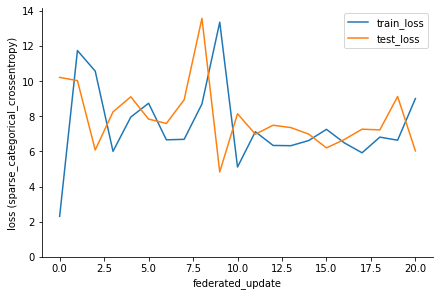

In [ ]:
fig, ax = plt.subplots(1, constrained_layout=True)
metrics_df.plot(ax=ax, y=["train_loss", "test_loss"])
ax.set_ylabel("loss (sparse_categorical_crossentropy)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(ymin=0)

(0.0, 1.0)

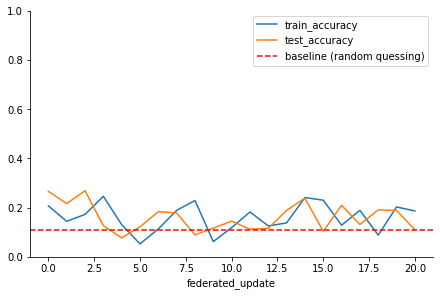

In [ ]:
fig, ax = plt.subplots(1, constrained_layout=True)
metrics_df.plot(ax=ax, y=["train_accuracy", "test_accuracy"])
ax.axhline(1 / 9, linestyle="--", color="r", label="baseline (random quessing)")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(0, 1)

## Unit test

Unit test your class or classes

In [ ]:
# your code here

## Visualize model behaviour with toy data

In [ ]:
## your code here

## Output of this notebook

The result of this notebook is a collection methods ready for evaluation with the real data.

You should export classes and functions to `model.py` with `# nbdev_build_lib` (workflows will do this automatically).

## You can move on to loss notebook!